# NLP on RIS report Demo

# Extracting Impressions from Reports

We assume all the files in a filder are text files, and hopefully all of themare report files. The function should iterate through all of the files and extract text that is recognized as *Beurteilung*. 

Unfortenatelly this is not always so straightforward. Some of the possible scenarios:
- Everything is as expected - impression is found between *Beurteilung* and a next header.
- There is *Beurteilung* header, but it never closes.
- *Beurteilung* is misspelled.
- *Beurteilung* is just a subsection but not clearly separated
- There is no *Beurteilung*

The list is of course not exhaustive.

To set the reports location, use the config.ini:

```ini
[INPUT]
REPORTS: /home/giga/Dropbox/USB/datasets/risnlp/inputs/reports_2
```

Now just run the following code, and reports will be returned as a dataframe. We will not persist the output.

In [3]:
import text
from text import common

constants = text.common.config_to_namedtuple('config.ini')

reports_dir = constants.INPUT.reports
df_impressions = text.extract_impressions_from_files(
    reports_dir
)
display(df_impressions.sample(10))

AttributeError: 'Config' object has no attribute 'INPUT'

# Converting Impressins to Sentences

Keep in mind that all fieldnames are defined in the config file (*config.ini*):
```ini
[FIELD_NAME]
ACCESSION_ID: accession_id
IMPRESSION_ID: impression_id
IMPRESSION: impression
SENTENCE_ID: sentence_id
SENTENCE: sentence
GROUND_TRUTH: ground_truth
PROCESSED: processed
```

These column names are used in the processing pipline, if you wish to use existing *csv* files, make sure you use these names or improve the existing code.

Now we can convert impressions to sentences. Since we don't have any ground truth defined, we will live this empty. Inputs ar of type iterable.

In [6]:
from risnlp.dataset import impressions_to_sentences

impressions_field_name = config.FIELD_NAME.impression
impressions = df_impressions[impressions_field_name]

impressions_id_field_name = config.FIELD_NAME.impression_id
impression_ids = df_impressions[impressions_id_field_name]

df_sentences = impressions_to_sentences(impressions, impression_ids)
display(df_sentences.sample(10))

,impression_id,sentence_id,sentence,ground_truth
654,25337647,2,Ein nicht vergrösserter Lymphknoten mesenteria...,
198,25346422,3,Neu hypermetaboler vergrösserter Lymphknoten r...,
411,24617153,1,Im Verlauf größenprogredienter Pleuraerguss li...,
373,24564479,1,Kein Hinweis auf weitere Tumormanifestationen.,
319,24712375,4,Eine Metastase erscheint hier unwahrscheinlich.,
560,25267684,2,Bei nur geringem Hypermetabolismus der Magenlä...,
158,24088783,1,Als postoperativ bzw. postentzündlich zu werte...,
297,24291622,9,MRI Schädel zu weiteren Abklärung empfohlen.,
575,24518412,1,40x26 mm messende Raumforderung im distalen Oe...,
680,24565635,0,Ca.,


# Splitting Dataset into Train/Test Data

For most algorithms we will need to split the dataset into training and test parts.

In [7]:
from risnlp.dataset import split_df

input_filed_name = config.FIELD_NAME.sentence
target_field_name = config.FIELD_NAME.ground_truth
split_by_field = config.FIELD_NAME.impression_id
X_train, X_test, y_train, y_test = split_df(
    df_sentences,
    input_filed_name, 
    target_field_name,
    split_by_field
)

display('X_train', X_train[:5])
display('y_train', y_train[:5])

'X_train'

11                                           Seit mind.
12    2012 bekanntes milchglasartiges und fein retik...
13    Dabei allerdings neu aufgetretener Hypermetabo...
14    Zusätzlich seit 10/2015 neu aufgetretenes, hyp...
15    Somit entspricht auch die zunehmende Verdichtu...
Name: sentence, dtype: object

'y_train'

11    
12    
13    
14    
15    
Name: ground_truth, dtype: object

Obviously the y data has no values. We will load a new dataset with this field populated when it comes to the algorithm testing time.

# Word Embedding

Let's first cover 2 ways we do word embedding. One is tfidf representation and the other is word2vec (will be used with conv net).

## tf-idf (short refresher)

It stands for term frequency-inverse document frequency.  A statistical measure of word importance. It is directly proportional to the number of occurences in a document, but is inverse proportinal to the number of occurences in the corpus.

$$tf-idf(d, t) = tf(t) * idf(d, t)$$
$$idf(d, t) = log [ \frac{n}{df(d, t)} ]$$

(In scikit the '+1' is added at the end, it is there to not completely exclude items appearing in all documents)

Or informally:
$$TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}$$

$$IDF(t) = log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term t in it}}\right)$$

## Word2Vec (even shorter refresher)

It constructs a vocabulary from the training text data and then learns vector representation of words. 
A simple way to investigate the learned representations is to find the closest words for a user-specified word.

## Training Vectorizers

Let's train the tf-idf vectorizer first. It will be trained and the train data. We will not persist the data for now.

In [8]:
from risnlp.dataset import train_tfidf_vectorizer


tfidf_vectorizer = train_tfidf_vectorizer(X_train)


print('Sample sentences')
sample_sentences = X_test[0:5]
[print(s) for s in sample_sentences]

# Test on the above sentences
result = tfidf_vectorizer.transform(sample_sentences)

display(result)


Sample sentences
Bei zwischenzeitlichem Status nach Gastrektomie bei Magenkarzinom findet sich eine neuaufgetretenes, FDG avides Weichteilplus präaortal mit Ausbreitung entlang der Arteria hepatica propria bis in den Leberhilus, hochgradig suspekt auf ein Lokalrezidiv, DD postoperative Veränderungen weniger wahrscheinlich.
Zudem Nachweis  zwei neuaufgetretene, morphologisch unauffälliger, jedoch kräftig FDG avider Lymphknoten retroperitoneal, ebenfalls Metastasensuspekt.
Neuaufgetretener fokaler Hypermetabolismus in der 1.
Rippe links mit korrelierender Osteolyse, sowie im BWK 11 mit hier Mehrsklerosieurng, ebenfalls suspekt.
Vorbestehende, ausgeprägten Mehrsklerosierungen des Skelettsystems weiterhin unklarer Ätiologie.


<5x1771 sparse matrix of type '<class 'numpy.float64'>'
	with 60 stored elements in Compressed Sparse Row format>

Here we see there is a sparse matrix that has 5 rows and (hopefully) 1793 columns. 
Columns represent dimensions, which are acquired from the unique words found in the X_training set.
We can also see that there are 36 words in these 5 sentences that were recognized 
(do note that there might be an overlap between the sentences).

In [9]:
X_train_vectorized = tfidf_vectorizer.transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

And now the word2vec model, which we will also train on the train data.

In [10]:
from risnlp.dataset import train_word2vec_vectorizer
w2v_vectorizer = train_word2vec_vectorizer(X_train)

Learned vocab len:  73


More about w2v once we come to the convNN model.

# Models

## Training a model

Now we can think about training the classification model.

But first, we've finally hit the wall with our data extraction pipeline. We need the target data for training, which cannot be extracted from the training data. 

So we will load the new dataset that has manually supplied targets.
It is just like the file we exported and then manually classified by an expert.

We will load a dataset on the sentence level of granularity, which is provided in the *config.ini*.

```ini
[INPUT]
SENTENCES: /home/giga/dev/python/risnlp/inputs/sentence_dataset.csv
```

And don't forget, you can perform various operations on the text prior to this (stemming, lematization, tokenization, short word removal etc.). The tf-idf vectorizer expects list of sentences as input, so make sure the tokenization is turned of in the *config.ini*.

```ini
[TEXT_OPERATIONS]
WORD_TOKENIZE: False
```

In [27]:
from case_runner import load_default_train_test
sentences_granularity = config.GRANULARITY.sentences
X_train, X_test, y_train, y_test = load_default_train_test(
    sentences_granularity,
    split_by_field
)

We need to create a vectorizer as well (tf-idf vectorizer).

In [28]:
tfidf_vectorizer = train_tfidf_vectorizer(X_train)


In [29]:
X_train_vectorized = tfidf_vectorizer.transform(X_train)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

Now we can train the model. Let's stert with the SVC model, that does dimensionality reduction beforehand.

In [30]:
from risnlp.models import standard
model = standard.fs_svc(X_train_vectorized, y_train)

Feature Selection SVC Model


Are you down for some viz? We will use test data as validate data.

In [31]:
%matplotlib inline
from risnlp import viz
y_hat = model.predict(X_test_vectorized)
viz.show_stats(y_test, y_hat)


                      0       1       2       3       4       5
-----------------------------------
     precission  |  00.46   00.59   00.67   00.31   00.48   00.42 
         recall  |  00.82   00.50   00.24   00.19   00.69   00.26 
             f1  |  00.59   00.54   00.35   00.24   00.56   00.32 
          count  |  28.00   20.00   17.00   21.00   16.00   19.00 
Done


How about some confusion matrices?

Confusion matrix, without normalization
[[23  1  1  0  2  1]
 [ 4 10  1  4  1  0]
 [ 3  1  4  4  3  2]
 [10  2  0  4  4  1]
 [ 2  0  0  0 11  3]
 [ 8  3  0  1  2  5]]
Normalized confusion matrix
[[0.82 0.04 0.04 0.   0.07 0.04]
 [0.2  0.5  0.05 0.2  0.05 0.  ]
 [0.18 0.06 0.24 0.24 0.18 0.12]
 [0.48 0.1  0.   0.19 0.19 0.05]
 [0.12 0.   0.   0.   0.69 0.19]
 [0.42 0.16 0.   0.05 0.11 0.26]]


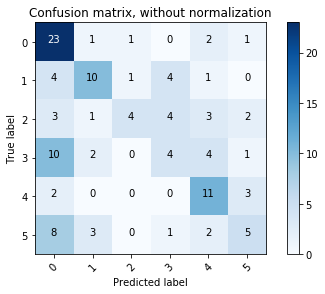

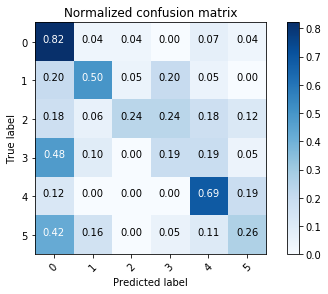

In [32]:
viz.plot_confusion_reports(y_test, y_hat)

## Dataset split on sentences
Let's try the same if just split sentences to train and no mather where they come from.